In [1]:
# !pip install "jax<=0.3.16" "jaxlib<=0.3.16"
# !pip install torchtext==0.6
# !pip install datasets
# !pip install chordparser

In [2]:
import pandas as pd
import os
from chord_critic import ChordsMetrics
from datasets import load_dataset
from datasets import concatenate_datasets
from datasets import DatasetDict
from datasets import Dataset
from collections import OrderedDict


C:\Users\agadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class SongsDataset(object):
    def __init__(self, path='dataset/chords_and_lyrics_en.pkl'):
        self.english_chords = pd.read_pickle(path)

    def get_songs_with_genre(self, genre_name):
        indexes = self.english_chords['genres'].apply(lambda x: genre_name in x)
        return self.english_chords[indexes]
    
    def get_by_artist_and_song_name(self, artist_name_song_name):
        index_artist = self.english_chords['artist_name'] == artist_name_song_name[0]
        index_song = self.english_chords['song_name'] == artist_name_song_name[1]
        return self.english_chords[index_artist & index_song]

songs_dataset = SongsDataset()

In [4]:
def songs_entry_to_chords(entry):
    bad_words = ('intro', 'bridge', 'instrumental', '2x', 'solo', '(', ')', 'hide')
    d = OrderedDict(entry['chords'].values[0])
    chords_str = ' '.join([v.strip() for v in d.values()])
    chords_filtered_list = [c for c in chords_str.split() if not any([bad_word in c.lower() for bad_word in bad_words])]
    return chords_filtered_list

class GenresBenchmarks(object):
    def __init__(self, songs_dataset, genres_names):
        self.songs_dataset = songs_dataset
        self.genres_names = genres_names
        self.genres_datasets = {genre_name: songs_dataset.get_songs_with_genre(genre_name) for genre_name in genres_names}

    def print_stats(self):
        for genre, dataset in self.genres_datasets.items():
            print(f'Found {len(dataset)} {genre} songs')

    def get_samples(self, sample_size=10):
        sampled_genres = {genre_name: self.genres_datasets[genre_name].sample(sample_size) for genre_name in self.genres_names}
        return sampled_genres

    def sample_random_benchmarks(self):
        pass

    def _benchmarks_for_song(self, song):
        chords_list = songs_entry_to_chords(song)
        print(chords_list)
        metric = ChordsMetrics(chords_list)
        return metric.scores
    
class SongsBenchmarks(object):
    def __init__(self, songs_dataset, songs_names):
        self.songs_dataset = songs_dataset
        self.songs_names = songs_names
        self.songs_data = {artist_song: songs_dataset.get_by_artist_and_song_name(artist_song)
                           for artist_song in songs_names}

    def get_benchmarks(self):
        benchmarks = [[song_name, self._benchmarks_for_song(self.songs_data[song_name])] for song_name in self.songs_names]
        return benchmarks

    def _benchmarks_for_song(self, song):
        chords_list = songs_entry_to_chords(song)
        print(chords_list)
        metric = ChordsMetrics(chords_list)
        return metric.scores

In [5]:
def get_benchmarks_for_songs(songs_names):
    sb = SongsBenchmarks(songs_dataset, songs_names)
    benchmarks = sb.get_benchmarks()
    for s,b in benchmarks:
        print(f'Benchmark for {" - ".join(s)}: {b}')
    
    return benchmarks

def get_benchmarks_for_chords(chords):
    metric = ChordsMetrics(chords)
    return metric.scores


In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
import textwrap

def plot_benchmarks(benchmarks):
    N = len(benchmarks)
    ind = np.arange(N)
    width = 0.25
    
    xvals = [b[1][0] for b in benchmarks]
    bar1 = plt.bar(ind, xvals, width) 
    
    yvals = [b[1][1] for b in benchmarks] 
    bar2 = plt.bar(ind + width, yvals, width) 
    
    zvals = [b[1][2] for b in benchmarks] 
    bar3 = plt.bar(ind + width * 2, zvals, width) 
    
    plt.xlabel("Songs") 
    plt.ylabel('Scores') 
    plt.title("Chords Evaluation Metrics") 
    pretty_titles = [' - '.join(b[0]) for b in benchmarks]
    wrapped_labels = [textwrap.fill(label, width=8) for label in pretty_titles]
    plt.xticks(ind + width, wrapped_labels) 
    plt.legend((bar1, bar2, bar3), ('Scale Criteria', 'Art Criteria', 'Structure Criteria') ) 
    plt.show() 

In [7]:
songs_names = [
        ('The Beatles', 'Let It Be'),
        ('Gotye', 'Somebody That I Used To Know'),
        ('OneRepublic', 'Apologize'),
        ('The Doors', 'Love Her Madly'),
        ('Justin Bieber', 'Baby'),
]
basic_chords = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#','Am','A#m','Bm','Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m']
import random
benchmarks = get_benchmarks_for_songs(songs_names) + [[('Random 32', ), get_benchmarks_for_chords([random.choice(basic_chords) for _ in range(32)])], [('BERT', ), get_benchmarks_for_chords('G C G C G'.split())]]

['C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C/B', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C/B', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'F', 'Em', 'Dm', 'C', 'Bb', 'Am', 'G', 'F', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C', 'G', 'Am', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'C/B', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'Am', 'Am/G', 'F', 'C', 'G', 'F', 'Em', 'Dm', 'C', 'F', 'Em', 'Dm', 'C', 'Bb', 'Am', 'G', 'F', 'C']
['Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 'C', 'Dm', 

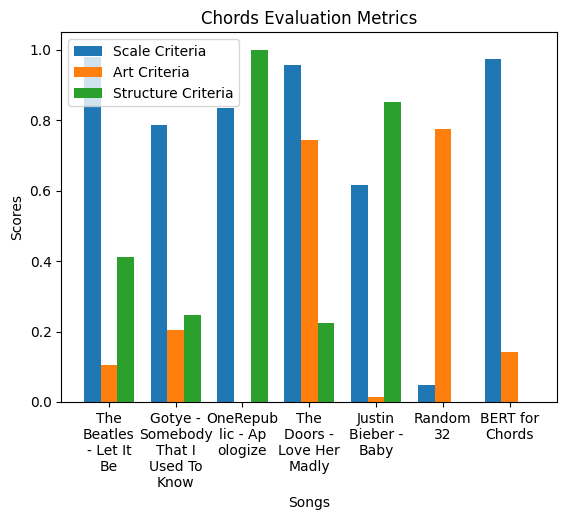

In [8]:
benchmarks[-1][0] = ('BERT for Chords', )
plot_benchmarks(benchmarks)